# US Immigration Analytics
### Data Engineering Capstone Project

#### Project Summary
The U.S. CBP (Customs and Border Protection) needs help to analyze the data on immigration and find patterns to help them make better decisions on increasing / decreasing staffing, identify busy ports, busy times of the year and trends over time. They have provided the immigration database and it will need to be augmented with demographics data, U.S. cities, ports and codes data sets. 

What they get in return are analytics tables which they can slice and dice with different topics (dimensions) that they are interested in. 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [3]:
# Do all imports and installs here
import configparser
import os
import re
import pandas as pd
import psycopg2
from collections import defaultdict
from datetime import datetime, timedelta
from pyspark.sql.functions import udf

In [45]:
config = configparser.ConfigParser()
config.read('dl.cfg')
os.environ['AWS_ACCESS_KEY_ID']=config['DEFAULT']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['DEFAULT']['AWS_SECRET_ACCESS_KEY']

### Step 1: Scope the Project and Gather Data

#### Scope 
This project will combine I94 immigration data, US demographic data, US Cities data and Airport codes data to setup a data mart with star schema for analysis.

* Data Sets 
    1. [I94 Immigration Data](https://travel.trade.gov/research/reports/i94/historical/2016.html)
    2. [U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)
    3. [Airport Code Table](https://datahub.io/core/airport-codes#data)
    4. [US Cities Data](https://simplemaps.com/data/us-cities)

* Tools
    * AWS S3: storage
    * AWS Redshift: data mart and data analysis
    * Python for data processing
        * Pandas - exploratory data analysis on small data set
        * PySpark - data processing on large data set

#### Describe and Gather Data 

| Data Set | Format | Description |
| ---      | ---    | ---         |
|[I94 Immigration Data](https://travel.trade.gov/research/reports/i94/historical/2016.html)| SAS | Data contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).|
|[U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/)| CSV | This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000.|
|[Airport Code Table](https://datahub.io/core/airport-codes#data)| CSV | This dataset contains information about airport codes, location, country and municipality|
|[US Cities Data](https://simplemaps.com/data/us-cities)| CSV | This dataset contains information US cities, state, county and location|

The project combines some important columns of i94 dataset, which has the port of entry code with airport codes table to get which city and state it belongs to. Next, this data is combined with US Cities data to get the full state name and then with US Demographics dataset to get the details on demographics of the city. 

Star schema has 4 dimensions:

    * Time
    * Cities
    * Flights
    * Visas
    
And one fact table:

    * Immigration

#### 1.1 Read sample immigration data

In [267]:
# Read in the data here
immi_fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immi = pd.read_sas(immi_fname, 'sas7bdat', encoding="ISO-8859-1")

In [268]:
# Get a sample of data
immi.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


In [3]:
f_immi = 'immigration_data_sample.csv'
df_immi = pd.read_csv(f_immi)
df_immi.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [7]:
# Check the columns
df_immi.columns

Index(['Unnamed: 0', 'cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port',
       'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa',
       'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd',
       'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum',
       'airline', 'admnum', 'fltno', 'visatype'],
      dtype='object')

In [8]:
# Which year does the data belong to
df_immi['i94yr'].unique()

array([ 2016.])

#### 1.2 Examine temperature data

In [187]:
f_temp = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temp = pd.read_csv(f_temp)
df_temp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [10]:
# Check size
df_temp.shape[0]

8599212

#### 1.3 Explore demographic data

In [88]:
df_dem = pd.read_csv('us-cities-demographics.csv', delimiter=';')
df_dem.head(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### 1.4 Explore airport data

In [11]:
f_airp = 'airport-codes_csv.csv'
df_airp = pd.read_csv(f_airp)
df_airp.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


#### 1.5 Explore US Cities data from https://simplemaps.com/data/us-cities

In [71]:
f_uscit = 'uscities.csv'
df_us = pd.read_csv(f_uscit)
df_us.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18680025,10768.0,shape,False,True,America/New_York,1,11229 11228 11226 11225 11224 11222 11221 1122...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,12531334,3267.0,shape,False,True,America/Los_Angeles,1,91367 90291 90293 90292 91316 91311 90035 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8586888,4576.0,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,6076316,4945.0,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7935,-96.7667,5910669,1522.0,shape,False,True,America/Chicago,1,75098 75287 75230 75231 75236 75237 75235 7525...,1840019440


In [ ]:
# Reference for Spark
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
#write to parquet
df_spark.write.parquet("sas_data2")
df_spark=spark.read.parquet("sas_data2")

In [27]:
df_spark.columns

['cicid',
 'i94yr',
 'i94mon',
 'i94cit',
 'i94res',
 'i94port',
 'arrdate',
 'i94mode',
 'i94addr',
 'depdate',
 'i94bir',
 'i94visa',
 'count',
 'dtadfile',
 'visapost',
 'occup',
 'entdepa',
 'entdepd',
 'entdepu',
 'matflag',
 'biryear',
 'dtaddto',
 'gender',
 'insnum',
 'airline',
 'admnum',
 'fltno',
 'visatype']

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

#### 2.1 Trim US Cities data
- Find if the city-state combination is unique
- Get the relavant columns

In [72]:
# Check if city state are unique - Total rows and unique combinations match
print(df_us.shape[0])
df_us.groupby(['city','state_id','lat','lng']).count().shape[0]

30409


30409

In [216]:
# Get only relavant columns
df_us_lim = df_us[['id', 'city', 'state_id', 'state_name', 'lat','lng']]
df_us_lim['lat_n'] = pd.to_numeric(df_us_lim['lat']).round(2)
df_us_lim['long_n'] = pd.to_numeric(df_us_lim['lng']).round(2)
df_us_lim.drop(columns=['lat','lng'], inplace=True)
df_us_lim.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://panda

,id,city,state_id,state_name,lat_n,long_n
0,1840034016,New York,NY,New York,40.69,-73.92
1,1840020491,Los Angeles,CA,California,34.11,-118.41
2,1840000494,Chicago,IL,Illinois,41.84,-87.69
3,1840015149,Miami,FL,Florida,25.78,-80.21
4,1840019440,Dallas,TX,Texas,32.79,-96.77


#### 2.2 Process temperature data
- Temperature data was explored to split latitude and longitude
- Location was rounded to see if it matches any other data
- It did not and it was concluded that there are large discrepancies between temperature location and cities location and hence we won't be using this dataset at all.

In [225]:
# Filter the data to US only and take average of 100 years from 1913 - 2012
df_temp_us = df_temp[df_temp['Country']=='United States']
df_temp_us['yr'] = pd.to_datetime(df_temp_us['dt']).dt.year
df_temp_us['month'] = pd.to_datetime(df_temp_us['dt']).dt.month
df_temp_us['lat_n'] = pd.to_numeric(df_temp_us['Latitude'].str[:-1]).round()
df_temp_us['long_n'] = pd.to_numeric(df_temp_us['Longitude'].str[:-1]).round()
df_temp_us.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,yr,month,lat_n,long_n
47555,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,1820,1,33.0,101.0
47556,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,1820,2,33.0,101.0
47557,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,1820,3,33.0,101.0
47558,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,1820,4,33.0,101.0
47559,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,1820,5,33.0,101.0


In [226]:
df_avg_temp = df_temp_us[(df_temp_us['yr']> 1912) & (df_temp_us['yr'] <= 2012)].groupby(['City', 'month', 'lat_n', 'long_n']).agg({"AverageTemperature":"mean"}).reset_index()
print(df_avg_temp.shape[0])
df_avg_temp.head()

3084


,City,month,lat_n,long_n,AverageTemperature
0,Abilene,1,33.0,101.0,5.52487
1,Abilene,2,33.0,101.0,7.89783
2,Abilene,3,33.0,101.0,12.08221
3,Abilene,4,33.0,101.0,17.18168
4,Abilene,5,33.0,101.0,21.87224


In [238]:
df_us_lim_int = df_us_lim.copy()
df_us_lim_int['lat'] = df_us_lim['lat_n'].round()
df_us_lim_int['long'] = df_us_lim['long_n'].round()
df_avg_temp.merge(df_us_lim_int, left_on=['City','lat_n','long_n'], right_on=['city','lat','long'], how='inner')

,City,month,lat_n_x,long_n_x,AverageTemperature,id,city,state_id,state_name,lat_n_y,long_n_y,lat,long


In [242]:
df_avg_temp[df_avg_temp['City'] == 'New York'].head(1)

,City,month,lat_n,long_n,AverageTemperature
1740,New York,1,41.0,75.0,-2.73261


In [243]:
df_us_lim_int.head(1)

,id,city,state_id,state_name,lat_n,long_n,lat,long
0,1840034016,New York,NY,New York,40.69,-73.92,41.0,-74.0


#### 2.3 Process and filter airport codes data
- Airport data was restricted to US only
- Latitude and Longitude columns were split
- Dropped NaN rows for iata_code and local_code columns
- Country and State columns were created from iso_region

In [170]:
# Restrict to USA only
df_airp_us = df_airp[df_airp['iso_country'] == 'US']
df_airp_us['iso_country'].unique()

array(['US'], dtype=object)

In [171]:
# Add lat and long columns
df_airp_us['lat_n'] = pd.to_numeric(df_airp_us['coordinates'].str.split(',').str[1]).round(2)
df_airp_us['long_n'] = pd.to_numeric(df_airp_us['coordinates'].str.split(',').str[0]).round(2)
df_airp_us.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lat_n,long_n
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125",40.07,-74.93
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022",38.70,-101.47
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968",59.95,-151.70
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172",34.86,-86.77
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087",35.61,-91.25


In [183]:
# Drop rows with no data for the two columns for port code
df_airp_clean = df_airp_us.dropna(subset=['iata_code', 'local_code'])
df_airp_clean.shape[0]

1969

In [184]:
df_airp_clean.drop(columns=['ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_country', 'gps_code', 'coordinates'], inplace=True)
df_airp_clean['country'] = df_airp_clean['iso_region'].str.split('-').str[0]
df_airp_clean['state'] = df_airp_clean['iso_region'].str.split('-').str[1]
df_airp_trim = df_airp_clean.drop(columns=['iso_region'])
print(df_airp_trim.shape[0])
df_airp_trim.head()

1969


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ip

,municipality,iata_code,local_code,lat_n,long_n,country,state
440,Key Largo,OCA,07FA,25.33,-80.27,US,FL
594,Pilot Station,PQS,0AK,61.93,-162.90,US,AK
673,Crested Butte,CSE,0CO2,38.85,-106.93,US,CO
1088,Johnson City,JCY,0TE7,30.25,-98.62,US,TX
1402,Palmer,PMX,13MA,42.22,-72.31,US,MA


In [181]:
df_airp_state = df_airp_trim.merge(df_us_lim, left_on=['municipality','state'], right_on=['city','state_id'], how='inner').drop(
    columns=['municipality','local_code', 'lat_n_x', 'long_n_x', 'country', 'state'])
print(df_airp_state.shape[0])
df_airp_state.head()

1671


,iata_code,id,city,state_id,state_name,lat_n_y,long_n_y
0,OCA,1840014253,Key Largo,FL,Florida,25.12,-80.41
1,PQS,1840023329,Pilot Station,AK,Alaska,61.94,-162.88
2,CSE,1840021464,Crested Butte,CO,Colorado,38.87,-106.98
3,JCY,1840019595,Johnson City,TX,Texas,30.27,-98.41
4,NUP,1840023364,Nunapitchuk,AK,Alaska,60.88,-162.46


#### 2.4 Transform demographics data
- It was found that the column Race doesn't always have same set of values
- So, columns Race and Count were dropped
- Dataset was de-duped and merged with US cities data

In [177]:
# Check the race column
print(df_dem.shape[0])
df_dem['Race'].unique()

2891


array(['Hispanic or Latino', 'White', 'Asian', 'Black or African-American',
       'American Indian and Alaska Native'], dtype=object)

In [178]:
# Due to some duplicates and race data unavailable for all cities for all types, we remove the race column
df_dem_simple = df_dem.drop(columns=['Race', 'Count'])
df_dem_simple= df_dem_simple.drop_duplicates()
print(df_dem_simple.shape[0])
df_dem_simple.head()

596


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ


In [179]:
df_dem_clean = df_dem_simple.merge(df_us_lim, left_on=['City', 'State'], right_on=['city', 'state_name'], how='inner')\
.drop(columns=['City', 'State'])
df_dem_clean.head()

,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,id,city,state_id,state_name,lat_n,long_n
0,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,1840005845,Silver Spring,MD,Maryland,39.00,-77.02
1,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,1840000461,Quincy,MA,Massachusetts,42.25,-71.02
2,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,1840014795,Hoover,AL,Alabama,33.38,-86.81
3,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,1840020411,Rancho Cucamonga,CA,California,34.12,-117.57
4,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,1840002791,Newark,NJ,New Jersey,40.72,-74.17


#### 2.5 Transform immigration data
- Upon exploring different months data, it was found that not every month's dataset has same number of columns
- Restricted columns to limited ones that would be useful for analysis
- Dropped some columns that have NaN values
- Merged this data with airport codes and demographics and cities datasets

In [269]:
immi.shape[0]

3096313

In [270]:
df_immi.columns

Index(['Unnamed: 0', 'cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port',
       'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa',
       'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd',
       'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum',
       'airline', 'admnum', 'fltno', 'visatype'],
      dtype='object')

In [271]:
df_immi_trim = df_immi[['cicid', 'arrdate', 'i94yr', 'i94mon', 'i94port', 'airline', 'fltno', 'visatype']]
df_immi_trim = immi[['cicid', 'arrdate', 'i94yr', 'i94mon', 'i94port', 'airline', 'fltno', 'visatype']]
df_immi_trim.head()

,cicid,arrdate,i94yr,i94mon,i94port,airline,fltno,visatype
0,6.0,20573.0,2016.0,4.0,XXX,NaN,NaN,B2
1,7.0,20551.0,2016.0,4.0,ATL,NaN,00296,F1
2,15.0,20545.0,2016.0,4.0,WAS,OS,93,B2
3,16.0,20545.0,2016.0,4.0,NYC,AA,00199,B2
4,17.0,20545.0,2016.0,4.0,NYC,AA,00199,B2


In [272]:
df_immi_trim = df_immi_trim.dropna(subset=['airline','visatype','i94port','airline','arrdate','i94mon','i94yr'])
df_immi_trim.head()

,cicid,arrdate,i94yr,i94mon,i94port,airline,fltno,visatype
2,15.0,20545.0,2016.0,4.0,WAS,OS,93,B2
3,16.0,20545.0,2016.0,4.0,NYC,AA,00199,B2
4,17.0,20545.0,2016.0,4.0,NYC,AA,00199,B2
5,18.0,20545.0,2016.0,4.0,NYC,AZ,00602,B1
6,19.0,20545.0,2016.0,4.0,NYC,AZ,00602,B2


In [273]:
# Merge the data with airport and state
df_immi_airp = df_immi_trim.merge(df_airp_state, how = "inner", left_on = "i94port", right_on = "iata_code")
print(df_immi_airp.shape[0])
df_immi_airp.head()

1237944


,cicid,arrdate,i94yr,i94mon,i94port,airline,fltno,visatype,iata_code,id,city,state_id,state_name,lat_n_y,long_n_y
0,24.0,20545.0,2016.0,4.0,TOR,MQ,03348,B2,TOR,1840021302,Torrington,WY,Wyoming,42.07,-104.17
1,603.0,20545.0,2016.0,4.0,TOR,JJ,08103,WT,TOR,1840021302,Torrington,WY,Wyoming,42.07,-104.17
2,604.0,20545.0,2016.0,4.0,TOR,AA,01259,WB,TOR,1840021302,Torrington,WY,Wyoming,42.07,-104.17
3,605.0,20545.0,2016.0,4.0,TOR,ZX,07356,WT,TOR,1840021302,Torrington,WY,Wyoming,42.07,-104.17
4,606.0,20545.0,2016.0,4.0,TOR,AA,01259,WB,TOR,1840021302,Torrington,WY,Wyoming,42.07,-104.17


In [274]:
# Merge the data with demographics
df_immi_airp_demo = df_immi_airp.merge(df_dem_clean, how = "inner", left_on = "id", right_on = "id")
print(df_immi_airp_demo.shape[0])
df_immi_airp_demo.head()

1128882


,cicid,arrdate,i94yr,i94mon,i94port,airline,fltno,visatype,iata_code,id,...,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,city_y,state_id_y,state_name_y,lat_n,long_n
0,27.0,20545.0,2016.0,4.0,BOS,LH,00422,B1,BOS,1840000455,...,669469,18350.0,190123.0,2.38,MA,Boston,MA,Massachusetts,42.32,-71.09
1,78.0,20545.0,2016.0,4.0,BOS,LH,00422,WT,BOS,1840000455,...,669469,18350.0,190123.0,2.38,MA,Boston,MA,Massachusetts,42.32,-71.09
2,79.0,20545.0,2016.0,4.0,BOS,LH,00422,WB,BOS,1840000455,...,669469,18350.0,190123.0,2.38,MA,Boston,MA,Massachusetts,42.32,-71.09
3,80.0,20545.0,2016.0,4.0,BOS,LH,00422,WT,BOS,1840000455,...,669469,18350.0,190123.0,2.38,MA,Boston,MA,Massachusetts,42.32,-71.09
4,81.0,20545.0,2016.0,4.0,BOS,LH,00422,WT,BOS,1840000455,...,669469,18350.0,190123.0,2.38,MA,Boston,MA,Massachusetts,42.32,-71.09


In [277]:
# Read US Cities Demo dataset file
demographics=spark.read.csv("us-cities-demographics.csv", sep=';', header=True)

In [278]:
# Print Schema to verify that all the columns are in "string" format
demographics.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The star schema below was chosen so that the following questions could be answered:

    * Identify the busy ports
    * Identify the busy times of the year
    * Trends over time
    * When and where should CBP increase or decrease staff based on it being busy on above parameters


#### 3.2 Mapping Out Data Pipelines

The project can be broken down in to two ETL loads: 
#### ETL - 1:
- **etl1.py** - File that was ran on EMR cluster to load S3 data. It outputs staging files back in S3. These are the steps: <br>
    1. EMR with applications: Spark 2.4.4, Zeppelin 0.8.2, Livy 0.6.0, JupyterHub 1.0.0 
    2. Release label: emr-5.28.0<br>
    3. To install the _configparser_ run the below command:<br> 
        _sudo pip install configparser_ <br>
    4. Copy the etl1.py to _/home/hadoop_ like below:<br>
        _scp -i <local_path/PEM_FILE.pem <local_path\etl1.py> hadoop@xxx.amazonaws.com:/home/hadoop/_<br>
    5. Run the job by typing the below command: <br> 
        _/usr/bin/spark-submit --master yarn ./etl1.py_<br>
    6. Uses _dl.cfg_ to load S3 keys

- **etl1.ipynb** - A Jupyter notebook that was used to build out Spark code


#### ETL - 2:
- **etl2.py** - File that creates Redshift tables, copies data from S3 and loads star schema.<br>
    1. _creates_tables.py_ script can be run to simply create/re-create tables<br>
    2. Uses _dwh2.cfg_ file to load the configurations for Redshift cluster and S3 bucket<br>
    3. File _etl2.ipynb_ is a Jupyter notebook to get step-by-step execution of the load<br>

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model


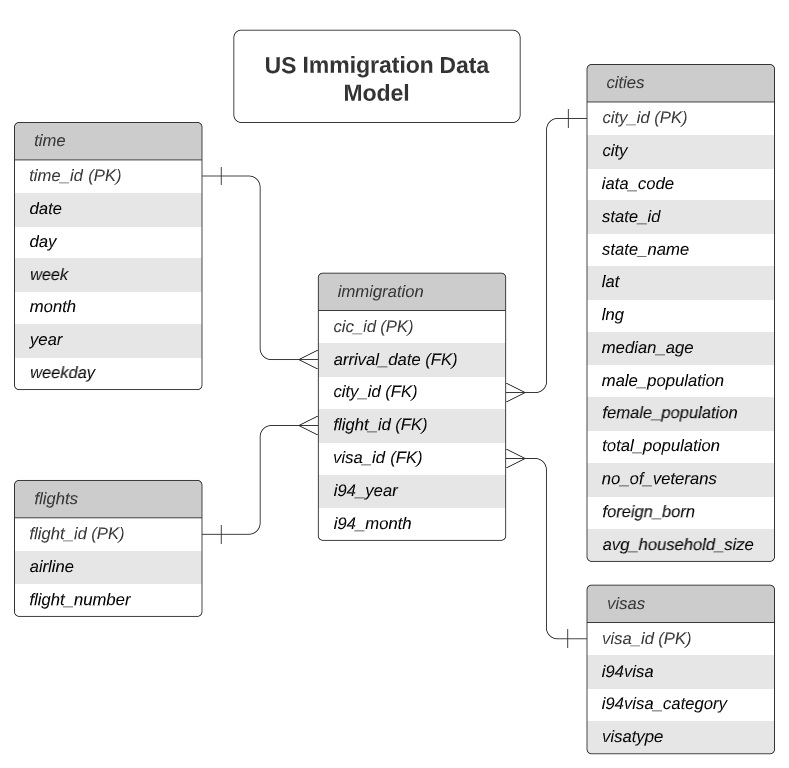

Run the files et1.py and etl2.py included in the project for data pipelines.

#### 4.2 Data Quality Checks

There are two data quality checks done when loading the star schema: 
    1. Check the count of tables is not zero for all tables
        For this, a row count of each of the tables is taken and an exception thrown if it is found to be zero. 
    2. Check whether there is consistency for visas. 
        There could be a possibility that bad data could creep in and the same visa could be categorized in to two different types. For this, a count is taken of all visa categories and compared with distinct of the same. 
        
**Note:** These checks are included in _etl2.py_ script

#### 4.3 Data dictionary 


__Table immigration__

| Column Name | Description |
| :--- | :--- |
| CICID | Primary Key, Unique ID for each record |
| arrival_date | Foreign Key of integer type with YYYYMMDD from time table |
| city_id | Foreign key of integer id from cities table |
| flight_id | Id of the flight. This is a FK to the flights dimension table |
| visa_id | Id of the visa. This is a FK to the visas dimension table |
| I94YR | Year of i94 record |
| I94MON | Month of i94 record |

__Table cities__

| Column Name | Description |
| :--- | :--- |
| city_id | City ID of the table. This is the PK. |
| city | city name |
| iata_code | code of the airport |
| state_id | Two letter id of the state |
| state_name | Name of the state |
| lat | GPS Latitude |
| lng | GPS Longitude |
| median_age | Median Age of the Immigrants |
| male_population | Number of male population |
| female_population | Number of female population |
| total_population | Number total of the population |
| no_of_veteran | Number of residents that are war veterans |
| foreign_born | Number of residents that born outside th United States |
| avg_household_size | Average size of houses in integer |

__Table time__

| Column Name | Description |
| :--- | :--- |
| time_id | Primary Key. This is the an INT of YYYYMMDD value |
| date | Date in format YYYY-MM-DD |
| day | Day number of the week |
| week | Week number of the year |
| month | Month number of the year |
| year | Year in YYYY format |
| weekday | Weekday number of the week |

__Table flights__

| Column Name | Description |
| :--- | :--- |
| flight_id | Autogenerated id of the flight. This is the PK. |
| airline |  Airline used to arrive in U.S. |
| flight_number | Flight number of Airline used to arrive in U.S. |

__Table visas__

| Column Name | Description |
| :--- | :--- |
| visa_id | Id of visa, autogenerated, PK |
| i94visa | Visa codes collapsed into three categories |
| i94visa_category | Categories expanded: (1 = Business; 2 = Pleasure; 3 = Student) |
| visatype | Class of admission legally admitting the non-immigrant to temporarily stay in U.S. |

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

The entire solution workload is based on AWS as it provides a low-cost, scalable, and highly reliable infrastructure platform.  Each of the components used, like S3, EMR (Spark) and Redshift has a resonable price and you end up paying for only the actual usage. So it can be prototyped and scaled up as data grows. 

__S3:__ Provides a relatively cheap, easy-to-use with scalability, high availability, security, and performance. This seems to be perfect to a staging area

__Spark:__ This is a decent framework for big data processing. It has built-in modules for streaming, SQL, machine learning and graph processing. So it can be scaled up, if needed. It provides implicit data parallelism and fault tolerance. 

__Propose how often the data should be updated and why__

The immigration data seems to be produced monthly and so that can be updated monthly. Other data is compiled by various departments and probably does not get updated that often. In this case, we can update it every quarter or half yearly. 

__Write a description of how you would approach the problem differently under the following scenarios:__

 * The data was increased by 100x.
 
 There are two ETL pipelines and if the data size is increased, more nodes would be needed to process the data in EMR (Spark) and output to parquet format. As parquet is readable faster, the second part of ETL should be able to handle the load. If not, even the Redshift cluster can be scaled up to handle it. S3 is always scalable, so it should be able to handle it. 
 
 
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
 The pipeline probably needs to be adjusted for upserts instead of inserts only. Frequent loading should not be and issue and a schduler would be needed to run it, like Cron at a fixed time of the day. 
 
 
 * The database needed to be accessed by 100+ people.
 
 Redshift can handle parallel access by thousands of people once it reaches there. It shouldn't be an issue. 